# Supplementary figures

In [1]:
from collections import OrderedDict, Counter
from multiprocessing import Pool
from functools import partial
import pickle

import numpy as np

import scipy.optimize
import scipy.integrate
import scipy.misc

# Matplotlib related imports 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

import estaudel.escaffolding as escaffolding
import estaudel.heredity.process
import estaudel.heredity.deterministic as ehd
from estaudel.heredity.stochastic import COLOR_NAMES

In [2]:
!mkdir -p supfig

# Parameter sets

In [3]:
Akeys = ['0excludes1', '1excludes0', 'coex', 'bistable']
rkeys = ['0fast', '1fast']

Aset = {
 'coex': np.array([[0.7, 0.3],
                 [0.5, 0.6]]),
 '1excludes0':np.array([[0.6, 0.7],
                      [0.4, 0.3]]),
 '0excludes1':np.array([[0.3, 0.6],
                       [0.5, 0.8]]),
 'bistable':np.array([[0.3, 0.7],
                      [0.8, 0.2]]),
}

r_base = 30
rset = {'0fast':np.array([1.2,1])*r_base,
        '1fast':np.array([1,1.2])*r_base}

B = 0.001

rlabel = {'1fast':COLOR_NAMES[1].capitalize()+' fast grower','0fast':COLOR_NAMES[0].capitalize()+' fast grower'}
alabel = {'bistable':'Bistable', 'coex':'Stable Coexistence', 
          '0excludes1':COLOR_NAMES[1].capitalize()+' extinction',
          '1excludes0':COLOR_NAMES[0].capitalize()+' extinction'}

# Stream plots in N0,N1 coordinates.

This figure shows the vector field of the Density-dependent ecology in the (N0,N1) coordinate space for four sets of parameters representative of the four qualitatively different behaviors.

In [4]:
def plot_vector_field(r, A, color='grey', text=True, ax=None, mx=None, B=None):
    """Plot the LV-vector field with null isoclines and equilibrium."""
    if ax is None:
        ax = plt.gca()
        
    # Flow 
    if mx is None:
        mx = np.max(1/A)
    dx = mx/30
    x = np.linspace(0,mx+dx,20)
    X,Y = np.meshgrid(x,x)
    
    flow = np.vectorize(lambda x,y: ehd.lotka_volterra([x,y],r=r,a=A),
                        signature='(),()->(2)')
    U = flow(X,Y)
    ax.streamplot(X, Y, U[:,:,0], U[:,:,1], density=1, color=color,linewidth=0.8)
    
    # Trivial null-isoclines
    ax.plot([0,mx],[0,0], color='b', ls='-', alpha=0.3, lw=5)
    ax.plot([0,0],[mx,0], color='r', ls='-', alpha=0.3, lw=5)

    # Non trivial null isoclines
    ax.plot([0, 1/A[1,0]], [1/A[1,1], 0], color='b', ls='-', alpha=0.3, lw=5)
    ax.plot([0, 1/A[0,0]], [1/A[0,1], 0], color='r', ls='-', alpha=0.3, lw=5)
    
    # Initial conditions
    if B is not None:
        ax.plot([0,B],[B,0], color='C4', ls='-', alpha=0.3, lw=5)
    
    # Equilibria 
    for e,s in ehd.list_equilibria(A):
        ax.scatter(*e, color='k' if s else 'w', edgecolor='w' if s else 'k')
        
    if text:
        ax.text(1/A[0,0], 0, r'$\frac{1}{a_{00}}$', color='r',
            horizontalalignment='center', verticalalignment='top')
        ax.text(0, 1/A[1,1], r'$\frac{1}{a_{11}}$', color='b',
            horizontalalignment='right', verticalalignment='center')
    
    ax.set(xlabel='$N_0$',ylabel='$N_1$',
           xticks=[],yticks=[],
           xlim=(-dx,mx+dx), ylim=(-dx,mx+dx))

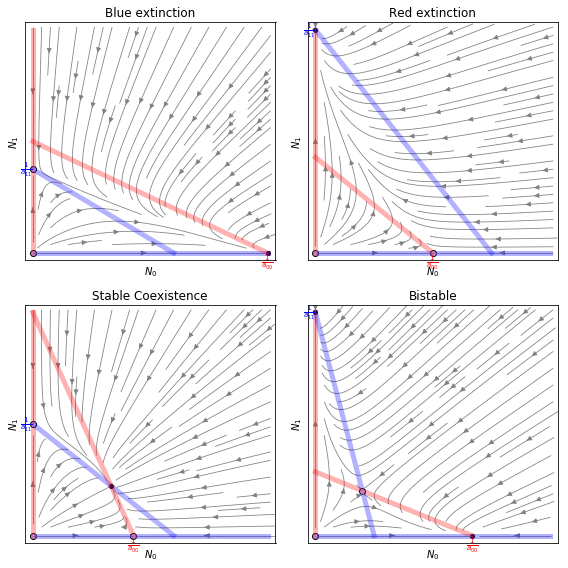

In [5]:
f, axes = plt.subplots(2,2,figsize=(8,8))
for k,ax in zip(Akeys, axes.flat):
    plot_vector_field(rset['0fast'],Aset[k], ax=ax)
    ax.set(title=alabel[k])
plt.tight_layout()
plt.savefig('supfig/paramspace_streamplot.pdf', bbox_inches='tight')

# Coordinates

This figure show the phase diagram in both (N0,N1) coordinate and (N,µ) coordinates.

In [6]:
def isocline_nontriviale_N(f,r,a):
    """Non trivial null-isocline for N in Nf coordinates."""
    return (r[0]*f - r[1]*f + r[1])/(a[0,0]*r[0]*f**2 - a[0,1]*r[0]*f**2 + a[0,1]*r[0]*f - a[1,0]*r[1]*f**2 + a[1,0]*r[1]*f + a[1,1]*r[1]*f**2 - 2*a[1,1]*r[1]*f + a[1,1]*r[1])
def isocline_nontrivale_f(N,r,a):
    """Non trivial null-isocline for f in Nf coordinates. """
    return (-a[0,1]*r[0]*N + a[1,1]*r[1]*N + r[0] - r[1])/((a[0,0]*r[0] - a[0,1]*r[0] - a[1,0]*r[1] + a[1,1]*r[1])*N)

def plot_nf_vectorfield(r, A, color='grey', ax=None, xmax=2.5, text=True, B=None):
    """Plot the LV-vector field in NF coordinates."""
    if ax is None:
        ax = plt.gca()
    margin_y = 0.01
    y = np.linspace(-margin_y,1+margin_y,20)
    x = np.linspace(0,xmax,20)

    # Isoclines
    ntN = isocline_nontriviale_N(y, r, A)
    ax.plot(ntN,y,color='orange', ls='-',alpha=0.3,lw=5)

    ntf = isocline_nontrivale_f(x, r,A)
    ax.plot(x,ntf,color='green', ls='-',alpha=0.3,lw=5)

    ax.plot([0,x.max()],[0,0], color='g', ls='-',alpha=0.3,lw=5)
    ax.plot([0,x.max()],[1,1], color='g', ls='-',alpha=0.3,lw=5)
    ax.plot([0,0],[0,1], color='orange', ls='-',alpha=0.3,lw=5)
    
    # Initial conditions
    if B is not None:
        ax.plot([B,B],[0,1], color='C4', ls='-', alpha=0.3, lw=5)
        
    if text:
        ax.text(1/A[0,0], 1, r'$\frac{1}{a_{00}}$', color='k',
                horizontalalignment='center', verticalalignment='bottom')
        ax.text(1/A[1,1], 0, r'$\frac{1}{a_{11}}$', color='k',
                horizontalalignment='center', verticalalignment='top')

    # Equilibria
    for e,s in ehd.list_equilibria(A):
        N = e[0]+e[1]
        if N:
            f = e[0]/N
            ax.scatter(N,f, color='k' if s else 'w', edgecolor='w' if s else 'k')

    # Flow 
    X,Y = np.meshgrid(x,y)
    flow = np.vectorize(lambda x,y: ehd.lotka_volterra_Nf([x,y],r=r,a=A),
                        signature='(),()->(2)')
    U = flow(X,Y)
    ax.streamplot(X, Y, U[:,:,0], U[:,:,1], density=1.2, color=color,linewidth=0.8)
    ax.set(xlabel='population size, N',ylabel='color, µ',
           ylim=(-margin_y,1+margin_y),
           xlim=(0,x.max()),xticks=[],yticks=[0,0.5,1])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


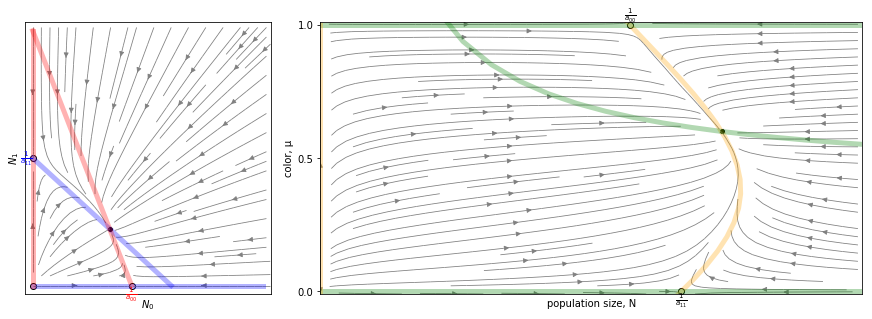

In [7]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan=1)
plot_vector_field(rset['0fast'], Aset['coex'], 'grey', ax=ax1)

ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan=2)
plot_nf_vectorfield(rset['0fast'], Aset['coex'], 'grey', ax=ax2)

plt.savefig('supfig/nf_coordinate_streamplot.pdf',bbox_inches='tight')

# Bifurcation diagrams

This figure show the bifurcation diagram for $µ_{eq}$ on parameter $T$

In [13]:
def plot_bifurcation_diagram(title, pstar, tstar, stability_of_01, continuation, stability_of_continuation,
                             color='C0', ax=None, plot_cont_info=False, **_):
    """Display bifurcation diagram"""
    
    if ax is None:
        ax = plt.gca()
        
    ax.grid(alpha=.1)

    # Draw the 0 and 1 branches
    for k,v in stability_of_01.items():
        for seg in v:
            ax.hlines(k,seg[1][0],seg[1][1],
                      linestyles='-' if seg[0] else ':',
                      color=color,
                      label='Stable' if seg[0] else 'Instable')
    
    # Draw the continuation branch
    ax.plot(continuation[0], continuation[1], color='C0',
           ls='-' if stability_of_continuation else ':')
    
    if plot_cont_info and cont_info is not None:
        ax.scatter(cont_info['t0'],cont_info['x0'], color='grey')
        ax.vlines(cont_info['tmin'],0,1, color='grey', alpha=0.1, lw=3)
        ax.vlines(cont_info['tmax'],0,1, color='grey', alpha=0.1, lw=3)
   
    ax.set(title=title, xlabel='Duration of the growth phase, T', 
       ylabel='Final Collective color, µ ')

In [25]:
# Compute all the bifurcation diagram
databif = {}
for i,akey in enumerate(Akeys):
    for j,rkey in enumerate(rkeys):
        databif[(i,j)] = {'akey':akey, 'rkey':rkey}
        databif[(i,j)].update(ehd.get_bifurcation_diagram(rset[rkey],Aset[akey],B,tmax=2))

/home/guilhem/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [72]:
def h(t, side, r, A, B):
    x,y = (0,1) if side==0 else (1,0)
    beta = A[x,x]*B
    alpha = r[x]*r[y]*(A[x,x]-A[y,x])/(r[x]*A[x,x]-r[y]*A[y,x])
    return beta - (1+beta)*np.exp(-alpha*t)+np.exp(-r[x]*t)

In [81]:
def bstar(t, side, r,A):
    x,y = (0,1) if side==0 else (1,0)
    beta = A[x,x]*B
    alpha = r[x]*r[y]*(A[x,x]-A[y,x])/(r[x]*A[x,x]-r[y]*A[y,x])
    return - (np.exp(-r[x]*t) - np.exp(-alpha*t)) / (A[x,x]*(1 - np.exp(-alpha*t)))

1.95976089941509e-104 0.3
1.7298706584208234e-87 0.8
1.536946440297401e-92 0.7
-8.580333704020022e-131 0.6
-1.5026756885355806e-156 0.3
-6.435250278015016e-131 0.8
-1.5026756885355806e-156 0.3
3.578054620114955e-122 0.2
3.203246213039749e-98 0.6
5.140636605297399e-116 0.3
1.1993035944197522e-118 0.3
-2.2540135328033135e-156 0.2
-8.580333704020022e-131 0.6
-1.5026756885355806e-156 0.3
-7.354571746302877e-131 0.7
3.516615059919709e-112 0.6


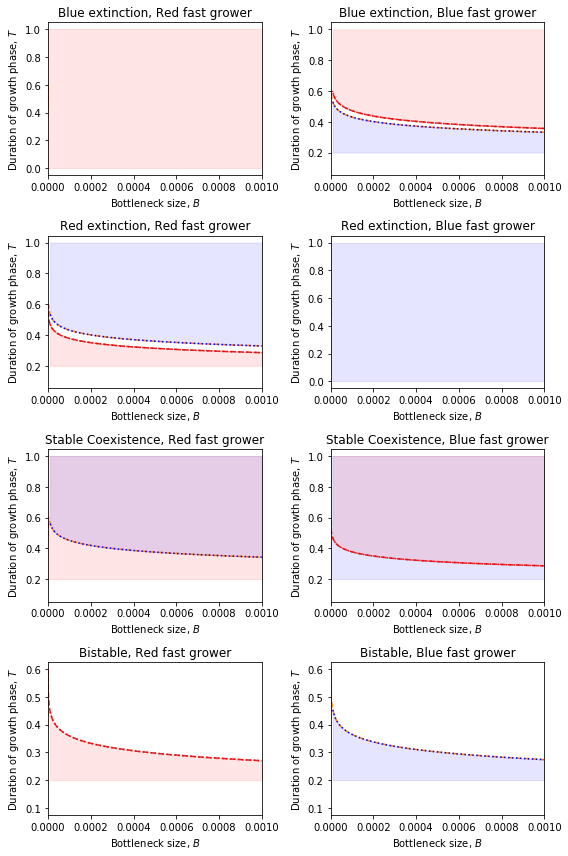

In [92]:
bspan = np.linspace(0,0.001, 100)
fig,axes = plt.subplots(4,2,figsize=(8,12))

for k,d in databif.items():
    d['title']=alabel[d['akey']]+', '+rlabel[d['rkey']]
    line = [[],[]]
    for b in bspan:
        for side in (0,1):
            hh = partial(h, side=side, r=rset[d['rkey']],A=Aset[d['akey']],B=B)
            val, _, conv, _ = scipy.optimize.fsolve(partial(h, side=side, r=rset[d['rkey']],A=Aset[d['akey']],B=b), 
                                                    0.1, full_output=True)  
            #print(val, conv)
            line[side].append(val[0] if conv==1 else np.nan)
    tspan = np.linspace(0.1, 0.6)
    print('='*80)
    print(bstar(10, side=0, r=rset[d['rkey']],A=Aset[d['akey']]), Aset[d['akey']][0,0])
    print(bstar(10, side=1, r=rset[d['rkey']],A=Aset[d['akey']]), Aset[d['akey']][1,1])

    print('='*80)
    axes[k].plot(bstar(tspan, side=0, r=rset[d['rkey']],A=Aset[d['akey']]), tspan, color='C1', ls='--')
    axes[k].plot(bstar(tspan, side=1, r=rset[d['rkey']],A=Aset[d['akey']]), tspan, color='C3', ls='--')

    axes[k].plot(bspan, line[0], color='b', ls=":")
    axes[k].plot(bspan, line[1], color='r', ls=":")

    xlim = [0.2,1]
    if all(np.isnan(line[1])) and all(np.isnan(line[0])):
        xlim[0] = 0
        
    if rset[d['rkey']][0]>rset[d['rkey']][1]:
        if all(np.isnan(line[1])):
            axes[k].fill_between(bspan,xlim[0],xlim[1], color='r', alpha=0.1)
        axes[k].fill_between(bspan,xlim[0],line[1], color='r', alpha=0.1)
        axes[k].fill_between(bspan,line[0],xlim[1], color='b', alpha=0.1)
    else:
        if all(np.isnan(line[0])):
            axes[k].fill_between(bspan,xlim[0],xlim[1], color='b', alpha=0.1)
        axes[k].fill_between(bspan,xlim[0],line[0], color='b', alpha=0.1)
        axes[k].fill_between(bspan,line[1],xlim[1], color='r', alpha=0.1)
    axes[k].set(xlim=(bspan[0],bspan[-1]))

    axes[k].set(title=d['title'])
    axes[k].set(xlabel='Bottleneck size, $B$', ylabel='Duration of growth phase, $T$')
plt.tight_layout()

1.1102230246251565e-16
0.0
1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16
0.0
0.0
0.0
0.0
1.1102230246251565e-16
0.0
0.0
0.0
1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16


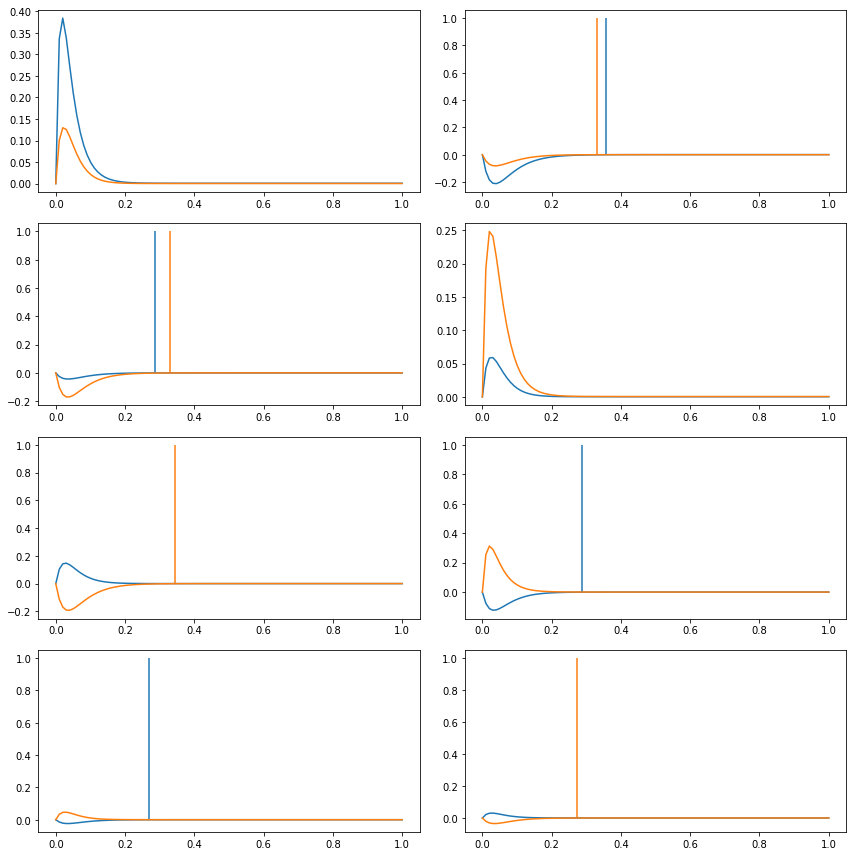

In [70]:
fig,axes = plt.subplots(4,2,figsize=(12,12))
for k,d in databif.items():
    d['title']=alabel[d['akey']]+', '+rlabel[d['rkey']]
    for side in (0,1):
        hh = partial(h, side=side, r=rset[d['rkey']],A=Aset[d['akey']],B=B)
        print(hh(0))
        tspan = np.linspace(0,1,100)
        l = axes[k].plot(tspan, hh(tspan))
        val, _, conv, _ = scipy.optimize.fsolve(partial(h, side=side, r=rset[d['rkey']],A=Aset[d['akey']],B=B), 
                                                0.1, full_output=True)        
        axes[k].vlines(val[0] if conv==1 else np.nan,0,1,color=l[0].get_color())
        #axes[k].semilogy()


plt.tight_layout()
plt.savefig('supfig/bifurcation_diagrams.pdf',bbox_to_inches='tight')

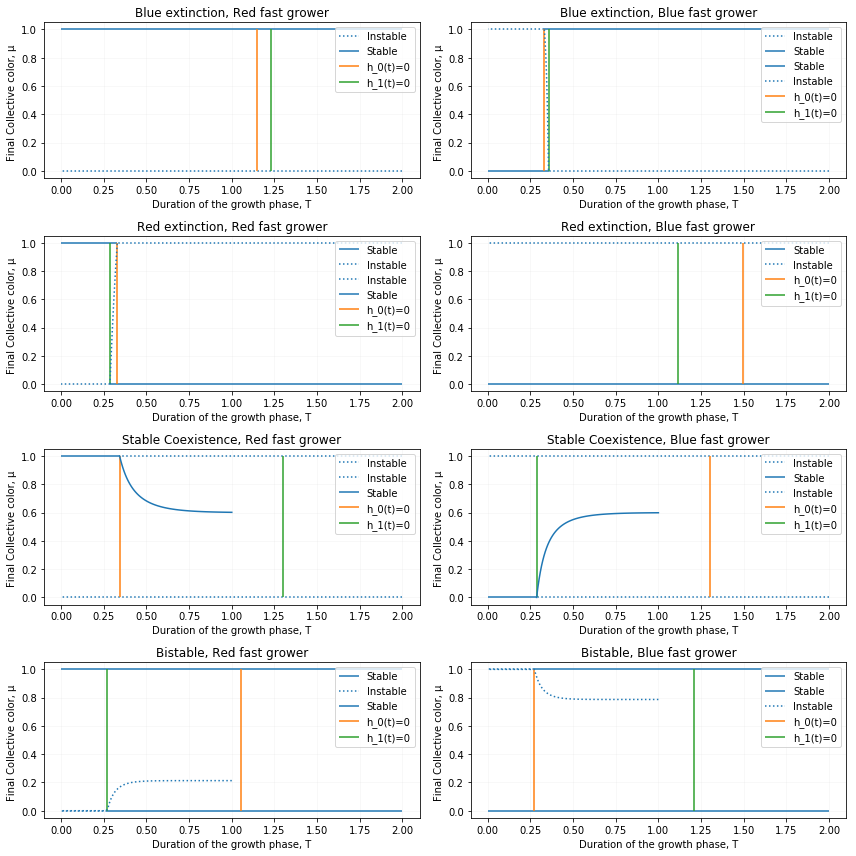

In [73]:
fig,axes = plt.subplots(4,2,figsize=(12,12))
for k,d in databif.items():
    d['title']=alabel[d['akey']]+', '+rlabel[d['rkey']]
    plot_bifurcation_diagram(ax=axes[k], **d)
    #v = get_tstar(rset[d['rkey']],Aset[d['akey']],B)
    
    v = []
    for side in (0,1):
        val, _, conv, _ = scipy.optimize.fsolve(partial(h, side=side, r=rset[d['rkey']],A=Aset[d['akey']],B=B), 
                                                0.1, full_output=True)
        v.append(val[0] if conv else np.nan)
    axes[k].vlines(v[0],0,1,color='C1', label='h_0(t)=0')
    axes[k].vlines(v[1],0,1,color='C2', label='h_1(t)=0')
    axes[k].legend()
    

plt.tight_layout()
plt.savefig('supfig/bifurcation_diagrams.pdf',bbox_to_inches='tight')

# p*

This figure show the equilibrium of the dynamical system as a function of the inter-color interaction parameters.

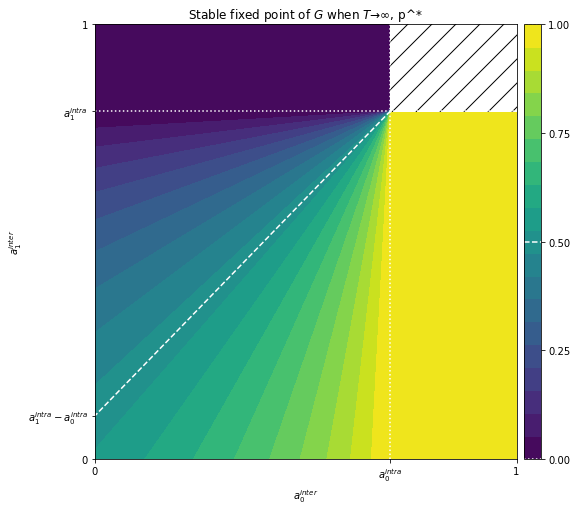

In [16]:
xx = np.linspace(0,1,200)
Xa,Ya = np.meshgrid(xx,xx)
a0 = 0.7
a1 = 0.8
f = np.vectorize(lambda x,y: estaudel.heredity.deterministic.pstar(np.array([[a0,y],
                                                                             [x,a1]])))
Za = f(Xa,Ya)

ticks = [0,0.25,0.5,0.75,1]
levels = np.linspace(0,1,20)

fig, ax = plt.subplots(1,1, figsize=(8,8))
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="4%", pad=0.11)

# Background 
im = ax.contourf(Xa, Ya, Za, cmap='viridis', levels=levels)
ax.contourf(Xa, Ya, np.int_(np.isnan(Za)), colors='white', levels=[0.1,1],  hatches='/') 
ax.contour(Xa,Ya,Za,colors='w',linestyles='--',levels=[0.5])

# Colorbar
cb = plt.colorbar(im, cax=cax, ticks=ticks,)
ax.hlines(a1,0,1,color='w',linestyles=':')
ax.vlines(a0,0,1,color='w',linestyles=':')
cax.plot([0,1],[0.5,0.5],color='w',ls='--')
cax.plot([0,1],[1,1],color='w',ls=':')
cax.plot([0,1],[0,0],color='w',ls=':')

# Set axis
ax.set(
        xlabel=r'$a_0^{inter}$', 
        ylabel=r'$a_1^{inter}$',
        title=r'Stable fixed point of $G$ when $T \to \infty$, p^*',
        xlim=(Xa[0,0],Xa[-1,-1]),
        ylim=(Ya[0,0],Ya[-1,-1]),
        xticks=[0,a0,1],
        xticklabels=[0,'$a_0^{intra}}$',1,],
        yticklabels=[0, '$a_1^{intra}-a_0^{intra}$','$a_1^{intra}$',1,],
        yticks=[0,a1-a0,a1,1]
);

plt.savefig('supfig/position_of_pstar.pdf',bbox_to_inches='tight')

In [17]:
!ls supfig

bifurcation_diagrams.pdf      paramspace_streamplot.pdf
nf_coordinate_streamplot.pdf  position_of_pstar.pdf
